# Homogenization of non-linear materials
The mechanical properties of structures composed of materials with different elasto-plastic properties can be estimated based on the models of Taylor or Sachs. In this tutorial, structures composed of different materials are created and their mechanical properties are investigated and compared to the Taylor and Sachs solution. Non-linear Finite Element Analysis is performed with the pyLabFEA package, see the <a rel="docs" href="https://ahartmaier.github.io/pyLabFEA/">online documentation</a> and the tutorial <a rel="Intro" href="https://ahartmaier.github.io/pyLabFEA/examples.html#tutorial-1-introduction">Introduction</a> for detailed information on the functionality of the package. For linear-elastic materials, analytical solutions for the homogenzition of their properties exist, as described in the tutorial <a rel="Comp" href="https://ahartmaier.github.io/pyLabFEA/examples.html#tutorial-2-composites">Composites</a>. This tutorial uses the matplotlib (https://matplotlib.org/) library for the visualization of results, and NumPy (http://www.numpy.org) for mathematical operations with arrays.

Author: Alexander Hartmaier, ICAMS / Ruhr-Universität Bochum, Germany

March 2020

This work is licensed under a Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">(CC-BY-NC-SA)</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

The pyLabFEA package comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under the conditions of
the GNU General Public License <a href="http://www.fsf.org/licensing/licenses/gpl.html">(GPLv3)</a> 


In [2]:
import pylabfea as FE
import matplotlib.pyplot as plt
import numpy as np
print('pyLabFEA version',FE.__version__)

pyLabFEA version 3.1


## 1. Create elastic-plastic materials

In the first step, the class ``Material`` in invoked to create objects for three materials, with identical elastic properties, but different yield strengths. The unit of stress is 1 MPa. All features of the class ``Material`` are described in the  <a rel="Intro" href="https://ahartmaier.github.io/pyLabFEA/pyLabFEA.html#module-pyLabMaterial">documentation</a>.

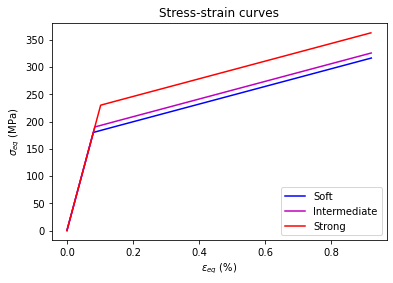

In [3]:
mat1 = FE.Material(name="Soft")      # invoke class to generate object for material 1
mat1.elasticity(E=200.e3, nu=0.3)    # define material with isotropic elasticity
mat1.plasticity(sy=180., khard=15.e3) # define material with isotropic plasticity and linear work hardening
mat2 = FE.Material(name="Intermediate")  # define second material
mat2.elasticity(E=200.e3, nu=0.3)    # identic elastic properties as mat1
mat2.plasticity(sy=190., khard=15.e3) # higher yield strength than mat1, but same w.h. coefficient
mat3 = FE.Material(name="Strong")        # define third material
mat3.elasticity(E=200.e3, nu=0.3)    # identic elastic properties as mat1
mat3.plasticity(sy=230., khard=15.e3) # higher yield strength than mat1 and mat2, but same w.h. coefficient
'Calculate and plot stress strain curves of materials'
mat1.calc_properties(eps=0.01)  # invoke method to calculate properties of material 
mat2.calc_properties(eps=0.01)  # and to store stress-strain data up to total strain eps=1%
mat3.calc_properties(eps=0.01)
plt.plot(mat1.prop['sty']['eeq']*100., mat1.prop['stx']['seq'], '-b')  # plot equiv. strain (eeq) vs. equiv. stress (seq)
plt.plot(mat2.prop['sty']['eeq']*100., mat2.prop['stx']['seq'], '-m')  # for uniaxial tensile stress in vertical direction (sty)
plt.plot(mat3.prop['sty']['eeq']*100., mat3.prop['stx']['seq'], '-r')
plt.title('Stress-strain curves')
plt.xlabel(r'$\epsilon_{eq}$ (%)')
plt.ylabel(r'$\sigma_{eq}$ (MPa)')
plt.legend([mat1.name, mat2.name, mat3.name], loc='lower right')
plt.show()

## 2. Laminate structure under iso-strain condition (Taylor model)

The class ``Model`` is invoked to generate an object for FEA. The methods of the class are used to generate the geomtry, to assign materials to sections, to establish boundary conditions, and to create the mesh. After these pre-processing steps, the solver is called to determine the solution for the deformed shape of the laminate structure in mechanical equilibrium under the applied boundary conditions. In the post-processing step, the results are evaluated and visualized. See the tutorial  <a rel="Intro" href="https://ahartmaier.github.io/pyLabFEA/examples.html#tutorial-1-introduction">Introduction</a> for the basic steps; all features of the class ``Model`` are described in the  <a rel="Intro" href="https://ahartmaier.github.io/pyLabFEA/pyLabFEA.html">documentation</a>.

The FE model of the laminate structure is subjected to a uniaxial stress along the lamellae of the structure, leading to iso-strain conditions, in which each section of the model, i.e. each lamella, undergoes the same total strain as the entire structure. The unit of length is 1 mm. In the first step, the model is loaded up to a stress slightly higher than the yield strength of ``mat1``, and the strains are analyzed.

2-d Model: iso-strain, uniaxial stress
--------------------------------------
Global total strain: (eps_11, eps_22) = (-0.000300,  0.000900)
Local total strain (element solution in different sections, Voigt tensor)
[-0.0003  0.0009 -0.0003  0.      0.     -0.    ] in Section 1, Material:  Soft
[-0.00028  0.00094 -0.00028  0.       0.      -0.     ] in Section 2, Material:  Intermediate
[-0.00028  0.00095 -0.00028  0.       0.       0.     ] in Section 3, Material:  Strong

Global plastic strain: (epl_11, epl_22) = (-0.000000,  0.000000)
Local plastic strain (element solution in different sections, Voigt tensor):
[-2.1e-05  4.2e-05 -2.1e-05  0.0e+00  0.0e+00  0.0e+00]  in Section 1, Material: Soft
[0. 0. 0. 0. 0. 0.]  in Section 2, Material: Intermediate
[0. 0. 0. 0. 0. 0.]  in Section 3, Material: Strong


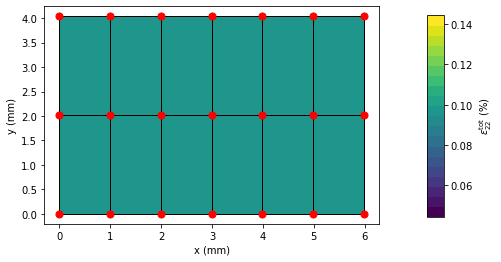

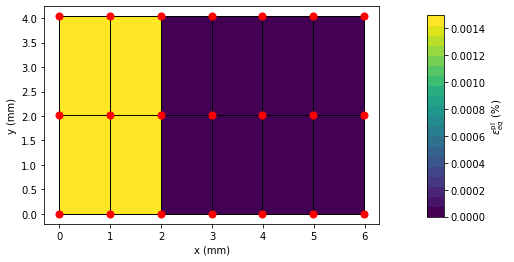

In [4]:
'laminate model is generated and elastic-plastic properties are assigned to each section'
fem = FE.Model(dim=2, planestress=True) # generate an object for a 2d finite element model with plane stress conditions
fem.geom([2, 2, 2], LY=4.)      # define 3 horizontal sections with 2 micron width per section, vertical dimension is 4 micron
fem.assign([mat1, mat2, mat3])  # assign the proper material to each section
fmat1 = 1./3.                   # identical volume fraction for each material
fmat2 = 1./3.
fmat3 = 1./3.
'boundary conditions: uniaxial stress along the  direction of the lamellae'
fem.bcleft(0.)                     # fix left and bottom boundary in normal directions
fem.bcbot(0.)                      # nodes on lhs boundary can move up and down, bottom nodes can move left and right
fem.bcright(0., 'force')           # free boundary condition on right edge of plane stress model -> uniaxial stress condition
ubc = 1.05*fem.leny*mat1.sy/mat1.E # displacement on top boundary corresponding to yield strength of mat1 (+5%)
fem.bctop(ubc, 'disp') # displacement applied to top nodes
'generate mesh'
fem.mesh(NX=6, NY=2)   # create structured mesh
'solution of equations for mechanical equilibrium'
fem.solve()            # solve system of equations
'post-processing'
fem.calc_global()      # calculate global stress and strain

print('2-d Model: iso-strain, uniaxial stress')
print('--------------------------------------')
print('Global total strain: (eps_11, eps_22) = (%9.6f, %9.6f)' 
      % (fem.glob['eps'][0].round(decimals=4), fem.glob['eps'][1].round(decimals=4)))
print('Local total strain (element solution in different sections, Voigt tensor)')
print(fem.element[0].eps.round(decimals=4),'in Section 1, Material: ', fem.element[0].Mat.name)
print(fem.element[4].eps.round(decimals=5),'in Section 2, Material: ', fem.element[4].Mat.name)
print(fem.element[8].eps.round(decimals=5),'in Section 3, Material: ', fem.element[8].Mat.name)
print('\nGlobal plastic strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['epl'][0].round(decimals=3), fem.glob['epl'][1].round(decimals=3)))
print('Local plastic strain (element solution in different sections, Voigt tensor):')
print(fem.element[0].epl.round(decimals=6),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[4].epl.round(decimals=6),' in Section 2, Material:',fem.element[4].Mat.name)
print(fem.element[8].epl.round(decimals=6),' in Section 3, Material:',fem.element[8].Mat.name)
'create graphical output of model'
fem.plot('strain2')                   # plot eps_22
fem.plot('peeq',vmin=0.,vmax=0.0015)  # plot eqiv. plastic strain

It is seen that the isostrain assumption is fulfilled to a very good degree, although the first section of the model, to which the soft material ``mat1`` is assigned starts to yield plastically, while the other sections remain linear-elastic.

The analysis of the stresses reveals that the stress in section 1 remains at the level of the flow stress in ``mat1`` (=yield strength + work hardening), while the stress in the two other sections is below the yield strength of those materials.


Global stress (MPa): (sig_11, sig_22) = ( 0.00, 186.22)
Local stress (element solution in different sections) (MPa):
[  0.   180.68   0.     0.     0.    -0.  ]  in Section 1, Material: Soft
[  0. 189.   0.   0.   0.  -0.]  in Section 2, Material: Intermediate
[  0. 189.   0.   0.   0.   0.]  in Section 3, Material: Strong


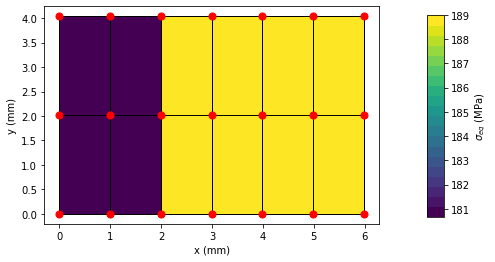

In [5]:
print('\nGlobal stress (MPa): (sig_11, sig_22) = (%5.2f, %5.2f)' 
      % (fem.glob['sig'][0].round(decimals=3), fem.glob['sig'][1].round(decimals=3)))
print('Local stress (element solution in different sections) (MPa):')
print(fem.element[0].sig.round(decimals=2),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[4].sig.round(decimals=2),' in Section 2, Material:',fem.element[4].Mat.name)
print(fem.element[8].sig.round(decimals=2),' in Section 3, Material:',fem.element[8].Mat.name)

fem.plot('seq')

In the next step the load is increased to exceed the yield strength of ``mat2``, and the strains are analysed again. Note that only the boundary conditions need to be changed on the existing model.

2-d Model: isostrain, uniaxial stress
-------------------------------------
Global total strain: (epl_11, epl_22) = (-0.000300,  0.001000)
Local total strain (element solution in different sections, Voigt tensor)
[-0.0003  0.001  -0.0003  0.      0.     -0.    ] in Section 1, Material:  Soft
[-0.00031  0.001   -0.0003   0.       0.      -0.     ] in Section 2, Material:  Intermediate
[-0.0003  0.001  -0.0003  0.      0.      0.    ] in Section 3, Material:  Strong

Global plastic strain: (epl_11, epl_22) = (-0.000000,  0.000000)
Local plastic strain (element solution in different sections, Voigt tensor):
[-4.5e-05  9.0e-05 -4.5e-05  0.0e+00  0.0e+00  0.0e+00]  in Section 1, Material: Soft
[-2.2e-05  4.4e-05 -2.2e-05  0.0e+00  0.0e+00  0.0e+00]  in Section 2, Material: Intermediate
[0. 0. 0. 0. 0. 0.]  in Section 3, Material: Strong


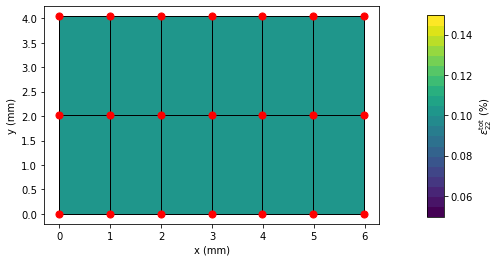

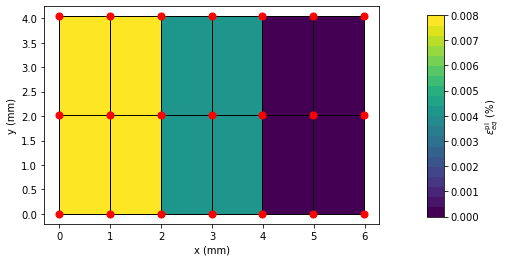

In [6]:
'increase load up to yield strength of mat2'
ubc = 1.05*fem.leny*mat2.sy/mat1.E   # displacement on top boundary corresponding to yield strength of mat2 (+5%)
fem.bctop(ubc, 'disp')  # displacement applied to top nodes
fem.solve()             # solve system of equations
fem.calc_global()       # calculate global stress and strain
print('2-d Model: isostrain, uniaxial stress')
print('-------------------------------------')
print('Global total strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['eps'][0].round(decimals=4), fem.glob['eps'][1].round(decimals=4)))
print('Local total strain (element solution in different sections, Voigt tensor)')
print(fem.element[0].eps.round(decimals=4),'in Section 1, Material: ', fem.element[0].Mat.name)
print(fem.element[4].eps.round(decimals=5),'in Section 2, Material: ', fem.element[4].Mat.name)
print(fem.element[8].eps.round(decimals=5),'in Section 3, Material: ', fem.element[8].Mat.name)
print('\nGlobal plastic strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['epl'][0].round(decimals=3), fem.glob['epl'][1].round(decimals=3)))
print('Local plastic strain (element solution in different sections, Voigt tensor):')
print(fem.element[0].epl.round(decimals=6),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[4].epl.round(decimals=6),' in Section 2, Material:',fem.element[4].Mat.name)
print(fem.element[8].epl.round(decimals=6),' in Section 3, Material:',fem.element[8].Mat.name)
'create graphical output of model'
fem.plot('strain2')
fem.plot('peeq',vmin=0.,vmax=0.008)

Again, the iso-strain assumption is fulfilled very well, because all sections individually are subject to the same vertical strain as the entire structure. The plastic strain in section 1 increases, and also in section 2 plastic yielding sets in.


Global stress (MPa): (sig_11, sig_22) = (-0.00, 190.56)
Local stress (element solution in different sections, Voigt tensor) (MPa):
[  0.   181.46   0.     0.     0.    -0.  ]  in Section 1, Material: Soft
[ -0.   190.71   0.     0.     0.    -0.  ]  in Section 2, Material: Intermediate
[  0.  199.5   0.    0.    0.    0. ]  in Section 3, Material: Strong


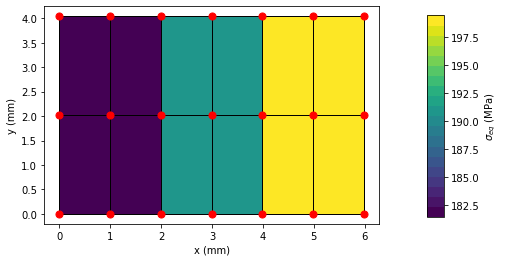

In [7]:
print('\nGlobal stress (MPa): (sig_11, sig_22) = (%5.2f, %5.2f)' 
      % (fem.glob['sig'][0].round(decimals=3), fem.glob['sig'][1].round(decimals=3)))
print('Local stress (element solution in different sections, Voigt tensor) (MPa):')
print(fem.element[0].sig.round(decimals=2),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[4].sig.round(decimals=2),' in Section 2, Material:',fem.element[4].Mat.name)
print(fem.element[8].sig.round(decimals=2),' in Section 3, Material:',fem.element[8].Mat.name)

fem.plot('seq')

The stress in sections 1 and 2 is bounded by the flow stress of the assigned materials, the stress in section 3 is still below the yield strength of ``mat3``.

Finally, the strain applied on the model is increased to $\epsilon_{22} = 1$%.

2-d Model: isostrain, uniaxial stress
-------------------------------------
Global total strain: (epl_11, epl_22) = (-0.004700,  0.010000)
Local total strain (element solution in different sections, Voigt tensor)
[-0.0047  0.01   -0.0023  0.      0.      0.    ] in Section 1, Material:  Soft
[-0.00467  0.01    -0.00228  0.       0.       0.     ] in Section 2, Material:  Intermediate
[-0.00465  0.01    -0.00229  0.       0.       0.     ] in Section 3, Material:  Strong

Global plastic strain: (epl_11, epl_22) = (-0.004000,  0.008000)
Local plastic strain (element solution in different sections, Voigt tensor):
[-0.004209  0.008417 -0.004209  0.        0.        0.      ]  in Section 1, Material: Soft
[-0.004186  0.008371 -0.004186  0.        0.        0.      ]  in Section 2, Material: Intermediate
[-0.004102  0.008187 -0.004085  0.        0.        0.      ]  in Section 3, Material: Strong


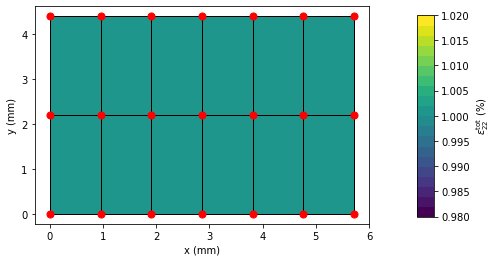

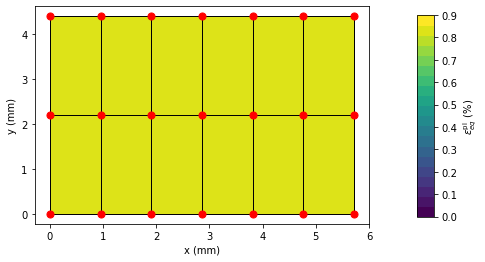

In [8]:
'increase load up to eps_22=1%'
ubc = 0.01*fem.leny     # displacement on top boundary corresponding to 1% total strain
fem.bctop(ubc, 'disp')  # displacement applied to top nodes
fem.solve()             # solve system of equations
fem.calc_global()       # calculate global stress and strain

print('2-d Model: isostrain, uniaxial stress')
print('-------------------------------------')
print('Global total strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['eps'][0].round(decimals=4), fem.glob['eps'][1].round(decimals=4)))
print('Local total strain (element solution in different sections, Voigt tensor)')
print(fem.element[0].eps.round(decimals=4),'in Section 1, Material: ', fem.element[0].Mat.name)
print(fem.element[4].eps.round(decimals=5),'in Section 2, Material: ', fem.element[4].Mat.name)
print(fem.element[8].eps.round(decimals=5),'in Section 3, Material: ', fem.element[8].Mat.name)
print('\nGlobal plastic strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['epl'][0].round(decimals=3), fem.glob['epl'][1].round(decimals=3)))
print('Local plastic strain (element solution in different sections, Voigt tensor):')
print(fem.element[0].epl.round(decimals=6),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[4].epl.round(decimals=6),' in Section 2, Material:',fem.element[4].Mat.name)
print(fem.element[8].epl.round(decimals=6),' in Section 3, Material:',fem.element[8].Mat.name)
'create graphical output of model'
fem.plot('strain2')
fem.plot('peeq',vmin=0.,vmax=0.9)

The deformation of the laminate structure  is now becoming visible, and the plastic strains in the different sections are rather similar, because most of the deformation is now of plastic nature, whereas the elastic contributions is quite small.


Global stress (MPa): (sig_11, sig_22) = ( 0.00, 334.93)
Local stress (element solution in different sections, Voigt tensor) (MPa):
[  0.  316.5   0.    0.    0.    0. ]  in Section 1, Material: Soft
[ -0.   325.75   0.     0.     0.     0.  ]  in Section 2, Material: Intermediate
[  0.   362.54   0.     0.     0.    -0.  ]  in Section 3, Material: Strong


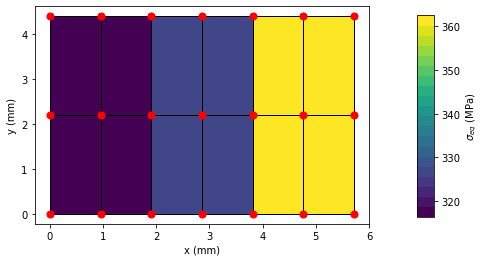

In [9]:
print('\nGlobal stress (MPa): (sig_11, sig_22) = (%5.2f, %5.2f)' 
      % (fem.glob['sig'][0].round(decimals=3), fem.glob['sig'][1].round(decimals=3)))
print('Local stress (element solution in different sections, Voigt tensor) (MPa):')
print(fem.element[0].sig.round(decimals=2),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[4].sig.round(decimals=2),' in Section 2, Material:',fem.element[4].Mat.name)
print(fem.element[8].sig.round(decimals=2),' in Section 3, Material:',fem.element[8].Mat.name)

fem.plot('seq')

The yield strength is now exceed in all sections, due to the linear work hardening with identical rate for each material, the difference in the yield strength is still reflected in the equivalent stress in each section, which corresponds to the flow stress of the assigned materials.

In the next step, the equiv. stress vs. equiv. strain diagram for the laminate structure is plotted together with those of the three materials.

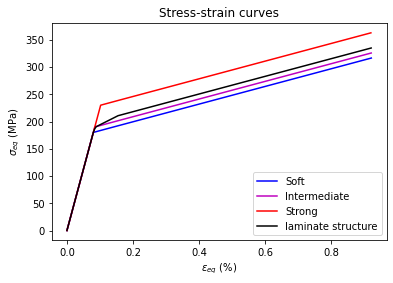

In [10]:
'plot stress-strain curves of materials and laminate structure'
plt.plot(mat1.prop['sty']['eeq']*100., mat1.prop['stx']['seq'], '-b')
plt.plot(mat2.prop['sty']['eeq']*100., mat2.prop['stx']['seq'], '-m')
plt.plot(mat3.prop['sty']['eeq']*100., mat3.prop['stx']['seq'], '-r')
plt.plot(FE.eps_eq(fem.egl)*100., FE.seq_J2(fem.sgl), '-k')  # calculate and plot equivalent values of global strain and stress
plt.title('Stress-strain curves')
plt.xlabel(r'$\epsilon_{eq}$ (%)')
plt.ylabel(r'$\sigma_{eq}$ (MPa)')
plt.legend([mat1.name, mat2.name, mat3.name, 'laminate structure'], loc='lower right')
plt.show()

It is seen that the global stress for the laminate structure corresponds to the average of the stresses in the three sections, given by the flow stress of the assigned materials. According to the Taylor model, the stress average is calculated at a constant total strain $\epsilon_\mathrm{tot}$, which is equal to the total strain $\epsilon^{(i)}$ in each section $i$ (iso-strain assumption), thus

\begin{equation}
\epsilon^{(i)} = \epsilon_\mathrm{tot}  \hspace{2em} (i=1,2,3).
\end{equation}

The global stress $\sigma_0$ is obtained by averaging the stresses $\sigma^{(i)}$ of the section according to their volume fractions $f_i$ , which yields

\begin{equation}
\sigma_0 = \sum\limits_{i=1}^3 f_i \, \sigma^{(i)}(\epsilon_\mathrm{tot}).
\end{equation}

In the next cell, the stresses according to the Taylor model are calculated and plotted together with the FE solution. To accomplish this, the FE model is restarted an the element solution in each section is recorded for small load increments until the total strain is reached.

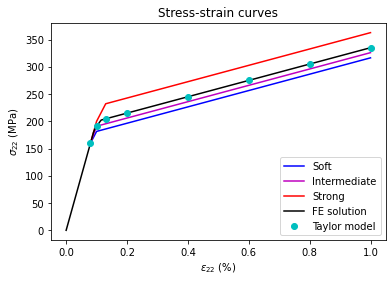

In [11]:
'initialize arrays for element stresses and strains'
sig1=[]
sig2=[]
sig3=[]
etot=[]
'reset model to start with zero load; geometry, sections, boundary conditions and mesh are kept'
fem.u=None # reset model
'calculate FE solution for small load increments'
for eps in [8.e-4, 1.e-3, 1.3e-3, 2.e-3, 4.e-3, 6.e-3, 8.e-3, 1.e-2]:
    ubc = eps*fem.leny      # calculate load increment
    fem.bctop(ubc, 'disp')  # apply displacement on top nodes
    fem.solve()             # solve system of equations
    sig1.append(fem.element[0].sig[1])  # store element solution for each section
    sig2.append(fem.element[4].sig[1])
    sig3.append(fem.element[8].sig[1])
    etot.append(fem.element[0].eps[1]*100)

'calculate weigthed average of stresses in different sections at constant total strains'
s_taylor = fmat1*np.array(sig1) + fmat2*np.array(sig2) + fmat3*np.array(sig3)

'plot stresses and strains'
plt.plot(etot, sig1, '-b')
plt.plot(etot, sig2, '-m')
plt.plot(etot, sig3, '-r')
plt.plot(fem.egl[:,1]*100., fem.sgl[:,1], '-k')  # plot vertical components of global strain and stress
plt.plot(etot, s_taylor, 'oc')
plt.title('Stress-strain curves')
plt.xlabel(r'$\epsilon_{22}$ (%)')
plt.ylabel(r'$\sigma_{22}$ (MPa)')
plt.legend([mat1.name, mat2.name, mat3.name, 'FE solution', 'Taylor model'], loc='lower right')
plt.show()

It is seen that the results of the Taylor model and the FE solution are in excellent agreement. Furthermore, the element solution for the uniaxial stress state corresponds to the stress-strain curves obtained for the individual materials.

## 3. Laminate model under iso-stress conditions (Sachs model)
In the next step, a new model with the identical geometry and materials is generated, but subjected to a uniaxial strain in the direction transversal to lamellae. This load case results in an iso-stress condition that can be described with the Sachs model.

2-d Model: iso-stress, uniaxial strain
--------------------------------------
Global total strain: (epl_11, epl_22) = ( 0.001500,  0.000000)
Local total strain (element solution in different sections, Voigt tensor)
[ 0.0016 -0.      0.      0.      0.     -0.    ] in Section 1, Material:  Soft
[0.00152 0.      0.      0.      0.      0.     ] in Section 2, Material:  Intermediate
[0.00142 0.      0.      0.      0.      0.     ] in Section 3, Material:  Strong

Global plastic strain: (epl_11, epl_22) = ( 0.000000, -0.000000)
Local plastic strain (element solution in different sections, Voigt tensor):
[ 0.000242 -0.000121 -0.000121  0.        0.        0.      ]  in Section 1, Material: Soft
[ 1.79e-04 -8.90e-05 -8.90e-05  0.00e+00  0.00e+00  0.00e+00]  in Section 2, Material: Intermediate
[0. 0. 0. 0. 0. 0.]  in Section 3, Material: Strong


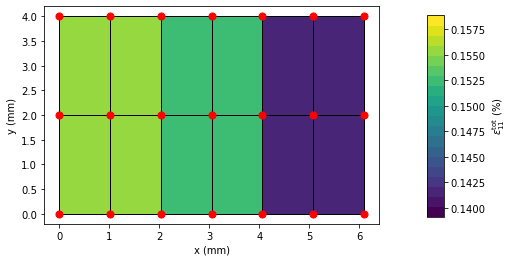

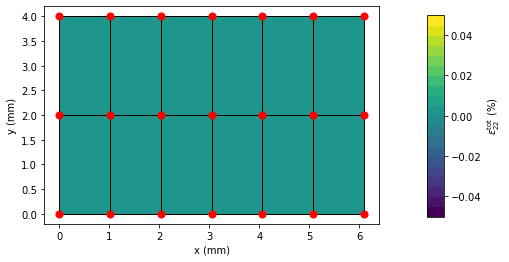

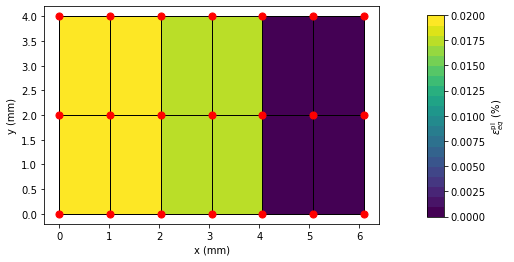

In [12]:
'mechanical boundary conditions for Sachs model (iso-stress) with uniaxial strain'
fem = FE.Model(dim=2, planestress=False) # generate an object for a 2d finite element model with plane strain conditions
fem.geom([2, 2, 2], LY=4.)      # define 3 horizontal sections with 2 micron width per section, vertical dimension is 4 micron
fem.assign([mat1, mat2, mat3])  # assign the proper material to each section
fmat1 = 1./3.                   # identical volume fraction for each material
fmat2 = 1./3.
fmat3 = 1./3.
'boundary conditions: uniaxial stress in transversal direction'
fem.bcleft(0.)                  # fix left and bottom boundary in normal directions
fem.bcbot(0.)                   # nodes on lhs boundary can move up and down, bottom nodes can move left and right
ubc = 0.0015*fem.lenx           # apply uniaxial strain eps_11 = 0.15%
fem.bcright(ubc, 'disp')        # apply displacement on rhs nodes
fem.bctop(0., 'disp')           # top boundary is fixed for uniaxial strain
'generate mesh'
fem.mesh(NX=6, NY=2)            # create structured mesh
'solution of equations for mechanical equilibrium'
fem.solve()                     # solve system of equations
'post-processing'
fem.calc_global()               # calculate global stress and strain
print('2-d Model: iso-stress, uniaxial strain')
print('--------------------------------------')
print('Global total strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['eps'][0].round(decimals=4), fem.glob['eps'][1].round(decimals=4)))
print('Local total strain (element solution in different sections, Voigt tensor)')
print(fem.element[0].eps.round(decimals=4),'in Section 1, Material: ', fem.element[0].Mat.name)
print(fem.element[4].eps.round(decimals=5),'in Section 2, Material: ', fem.element[4].Mat.name)
print(fem.element[8].eps.round(decimals=5),'in Section 3, Material: ', fem.element[8].Mat.name)
print('\nGlobal plastic strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['epl'][0].round(decimals=3), fem.glob['epl'][1].round(decimals=3)))
print('Local plastic strain (element solution in different sections, Voigt tensor):')
print(fem.element[0].epl.round(decimals=6),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[4].epl.round(decimals=6),' in Section 2, Material:',fem.element[4].Mat.name)
print(fem.element[8].epl.round(decimals=6),' in Section 3, Material:',fem.element[8].Mat.name)
fem.plot('strain1')
fem.plot('strain2')
fem.plot('peeq',vmin=0., vmax=0.02)

It is seen that the uniaxial strain condition is applied and that sections 1 and 2 already underwent plastic deformation.


Global stress (MPa): (sig_11, sig_22) = (382.28, 183.86)
Local stress (element solution in different sections, Voigt tensor) (MPa):
[382.28 198.36 198.36   0.     0.    -0.  ]  in Section 1, Material: Soft
[382.28 189.38 189.38   0.     0.     0.  ]  in Section 2, Material: Intermediate
[382.28 163.83 163.83   0.     0.     0.  ]  in Section 3, Material: Strong


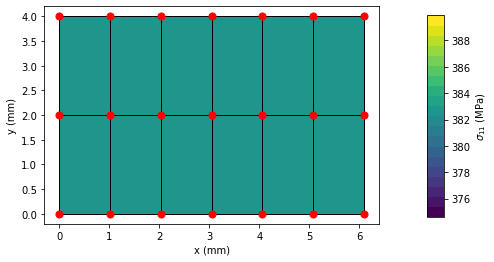

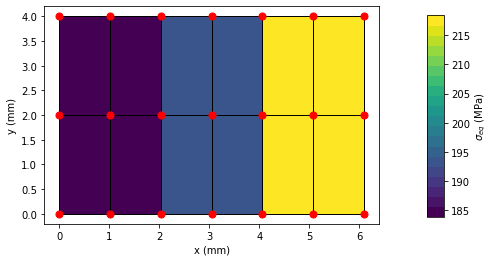

In [13]:
print('\nGlobal stress (MPa): (sig_11, sig_22) = (%5.2f, %5.2f)' 
      % (fem.glob['sig'][0].round(decimals=3), fem.glob['sig'][1].round(decimals=3)))
print('Local stress (element solution in different sections, Voigt tensor) (MPa):')
print(fem.element[0].sig.round(decimals=2),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[4].sig.round(decimals=2),' in Section 2, Material:',fem.element[4].Mat.name)
print(fem.element[8].sig.round(decimals=2),' in Section 3, Material:',fem.element[8].Mat.name)
fem.plot('stress1')
fem.plot('seq')

Also the iso-stress condition in loading direction is fullfilled. Transversal stresses occur due to the restricted cross-contraction, they are different in each section, due to their different plastic deformation, which is reflected in the different equivalent stresses in each section. Note also, that the stress state has a significant triaxiality, because the stress component in x-direction is larger than the equivalent stress, which is independent of hydrostatic stress components.

Now, the strain is increased to $\epsilon_\mathrm{tot} = 1\%$, and the results are analyzed.

2-d Model: iso-stress, uniaxial strain
--------------------------------------
Global total strain: (epl_11, epl_22) = ( 0.010000,  0.000000)
Local total strain (element solution in different sections, Voigt tensor)
[ 0.0101 -0.      0.      0.      0.      0.    ] in Section 1, Material:  Soft
[0.01004 0.      0.      0.      0.      0.     ] in Section 2, Material:  Intermediate
[ 0.00989 -0.       0.       0.       0.       0.     ] in Section 3, Material:  Strong

Global plastic strain: (epl_11, epl_22) = ( 0.005000, -0.003000)
Local plastic strain (element solution in different sections, Voigt tensor):
[ 0.005545 -0.002772 -0.002772  0.        0.        0.      ]  in Section 1, Material: Soft
[ 0.005482 -0.002741 -0.002741  0.        0.        0.      ]  in Section 2, Material: Intermediate
[ 0.005231 -0.002615 -0.002615  0.        0.        0.      ]  in Section 3, Material: Strong


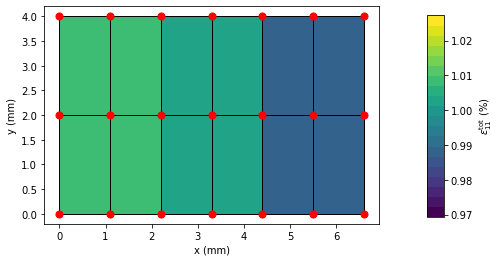

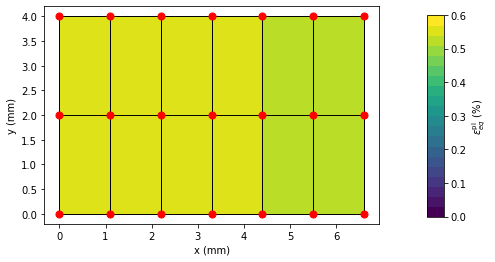

In [14]:
'increase load'
ubc = 0.01*fem.lenx
fem.bcright(ubc, 'disp') # displacement on rhs nodes
fem.solve()              # solve equations for mechanical equilibrium
fem.calc_global()        # calculate global stress and strain
print('2-d Model: iso-stress, uniaxial strain')
print('--------------------------------------')
print('Global total strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['eps'][0].round(decimals=4), fem.glob['eps'][1].round(decimals=4)))
print('Local total strain (element solution in different sections, Voigt tensor)')
print(fem.element[0].eps.round(decimals=4),'in Section 1, Material: ', fem.element[0].Mat.name)
print(fem.element[4].eps.round(decimals=5),'in Section 2, Material: ', fem.element[4].Mat.name)
print(fem.element[8].eps.round(decimals=5),'in Section 3, Material: ', fem.element[8].Mat.name)
print('\nGlobal plastic strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['epl'][0].round(decimals=3), fem.glob['epl'][1].round(decimals=3)))
print('Local plastic strain (element solution in different sections, Voigt tensor):')
print(fem.element[0].epl.round(decimals=6),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[4].epl.round(decimals=6),' in Section 2, Material:',fem.element[4].Mat.name)
print(fem.element[8].epl.round(decimals=6),' in Section 3, Material:',fem.element[8].Mat.name)
fem.plot('strain1')
fem.plot('peeq',vmin=0., vmax=0.6)

Similar to the iso-strain conditions, the model is now fully plastified. Under uniaxial strain, however, the plastic deformation is smaller than for uniaxial stress, due to the pronounced stress triaxiality that is caused by the restricted cross-contraction.

Looking at the stresses reveals these strong components transversal to the loading direction.


Global stress (MPa): (sig_11, sig_22) = (1858.59, 1570.71)
Local stress (element solution in different sections, Voigt tensor) (MPa):
[1858.59 1588.67 1588.67    0.      0.      0.  ]  in Section 1, Material: Soft
[1858.59 1579.69 1579.69    0.      0.      0.  ]  in Section 2, Material: Intermediate
[1858.59 1543.77 1543.77    0.      0.      0.  ]  in Section 3, Material: Strong


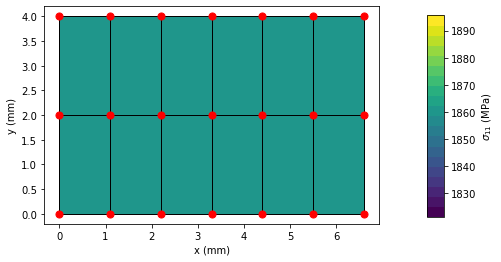

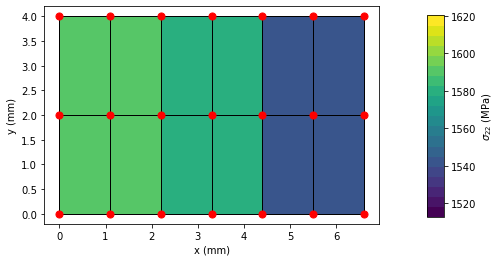

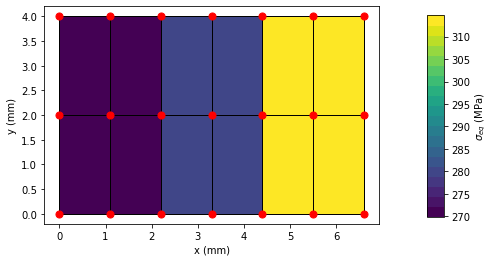

In [15]:
print('\nGlobal stress (MPa): (sig_11, sig_22) = (%5.2f, %5.2f)' 
      % (fem.glob['sig'][0].round(decimals=3), fem.glob['sig'][1].round(decimals=3)))
print('Local stress (element solution in different sections, Voigt tensor) (MPa):')
print(fem.element[0].sig.round(decimals=2),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[4].sig.round(decimals=2),' in Section 2, Material:',fem.element[4].Mat.name)
print(fem.element[8].sig.round(decimals=2),' in Section 3, Material:',fem.element[8].Mat.name)
fem.plot('stress1')
fem.plot('stress2')
fem.plot('seq')

The iso-stress condition in loading direction is fullfilled, i.e. the horizontal stress component is constant throughout the model. However, it is seen that due to the severe stress triaxiality, there are different equivalent stresses in the different sections, following the strengths of the assigned materials.

The homogenization under iso-stress conditions is covered by the Sachs model, where the stress in each section $\sigma^{(i)}$ equals the global stress $\sigma_0$, thus

\begin{equation}
\sigma^{(i)} = \sigma_0  \hspace{2em} (i=1,2,3).
\end{equation}

The global total strain is given as the weighted average of the total strain in each section $\epsilon_\mathrm{tot}^{(i)}$ at a constant stress $\sigma_0$ with the volume fractions $f_i$ as weights, which yields

\begin{equation}
\epsilon_\mathrm{tot} = \sum\limits_{i=1}^3 f_i \, \epsilon_\mathrm{tot}^{(i)}(\sigma_0).
\end{equation}

In the next cell, the strains according to the Sachs model are calculated from the element solutions in each section and plotted together with the global solution.

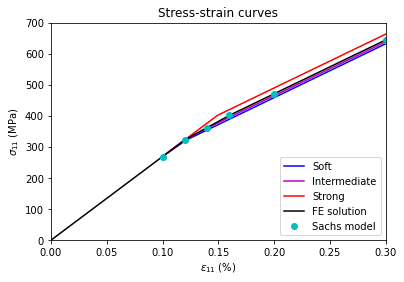

In [16]:
sig0=[]
seq1=[]
seq2=[]
seq3=[]
et1=[]
et2=[]
et3=[]
eq1=[]
eq2=[]
eq3=[]
fem.u=None # reset model
for eps in [1.e-3, 1.2e-3, 1.4e-3, 1.6e-3, 2.e-3, 3.e-3, 6.5e-3, 1.e-2]:
    ubc = eps*fem.lenx          # uniaxial strain increments
    fem.bcright(ubc, 'disp')    # apply displacement on rhs nodes
    fem.solve()                 # solve system of equations
    sig0.append(fem.element[0].sig[0])
    et1.append(fem.element[0].eps[0]*100)
    et2.append(fem.element[4].eps[0]*100)
    et3.append(fem.element[8].eps[0]*100)
    seq1.append(FE.seq_J2(fem.element[0].sig))
    seq2.append(FE.seq_J2(fem.element[4].sig))
    seq3.append(FE.seq_J2(fem.element[8].sig))
    eq1.append(FE.eps_eq(fem.element[0].eps)*100)
    eq2.append(FE.eps_eq(fem.element[4].eps)*100)
    eq3.append(FE.eps_eq(fem.element[8].eps)*100)

'weigthed average of strains in different sections at same stress level'
e_sachs = fmat1*np.array(et1) + fmat2*np.array(et2) + fmat3*np.array(et3)   
'plot stresses and strains'
plt.plot(et1, sig0, '-b', label=mat1.name)
plt.plot(et2, sig0, '-m', label=mat2.name)
plt.plot(et3, sig0, '-r', label=mat3.name)
plt.plot(fem.egl[:,0]*100, fem.sgl[:,0], '-k', label='FE solution')  # plot horizontal components of global strain and stress
plt.plot(e_sachs, sig0, 'oc', label='Sachs model')
plt.xlim((0,0.3))
plt.ylim((0,700))
plt.title('Stress-strain curves')
plt.xlabel(r'$\epsilon_{11}$ (%)')
plt.ylabel(r'$\sigma_{11}$ (MPa)')
plt.legend(loc='lower right')
plt.show()

The numerical solution and the Sachs model are in excellent agreement. Due to the large stress triaxility, the values of the flow stress are quite high, such that the differences between the different sections, caused by the comparatively small differences in the yield strength of each material, appear to be small in comparison. Thus, the evolution of equivalent stresses and equivalent strains in the elements is also evaluated. 

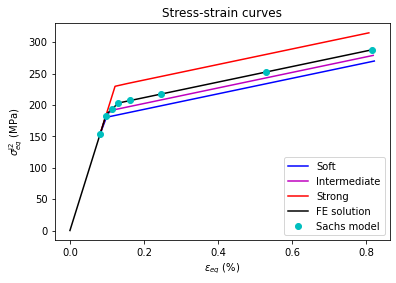

In [17]:
'weigthed average of equiv. strains and stresses in different sections'
eeq_sachs = fmat1*np.array(eq1) +  fmat2*np.array(eq2) +  fmat3*np.array(eq3)
seq_sachs = fmat1*np.array(seq1) + fmat2*np.array(seq2) + fmat3*np.array(seq3)
'plot stresses and strains'
plt.plot(eq1, seq1, '-b', label=mat1.name)
plt.plot(eq2, seq2, '-m', label=mat2.name)
plt.plot(eq3, seq3, '-r', label=mat3.name)
plt.plot(FE.eps_eq(fem.egl)*100., FE.seq_J2(fem.sgl), '-k', label='FE solution')  # plot horizontal components of global strain and stress
plt.plot(eeq_sachs, seq_sachs, 'oc', label='Sachs model')
plt.title('Stress-strain curves')
plt.xlabel(r'$\epsilon_{eq}$ (%)')
plt.ylabel(r'$\sigma_{eq}^\mathrm{J2}$ (MPa)')
plt.legend(loc='lower right')
plt.show()

The analysis of eqivalent stresses and strains makes the influence of the material properties more visible. In the next plot, Taylor and Sachs solutions are compared.

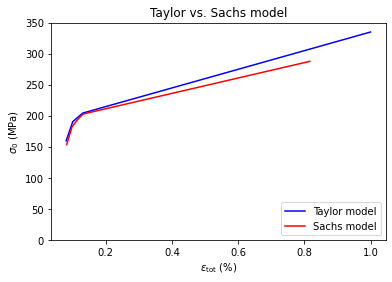

In [18]:
plt.plot(etot, s_taylor, '-b', label='Taylor model')
plt.plot(eeq_sachs, seq_sachs, '-r', label='Sachs model')
plt.title('Taylor vs. Sachs model')
plt.xlabel(r'$\epsilon_\mathrm{tot}$ (%)')
plt.ylabel(r'$\sigma_0$ (MPa)')
plt.legend(loc='lower right')
plt.ylim((0,350))
plt.show()

The Taylor model (iso-strain) results in a stronger material behavior than the Sachs model (iso-stress), in which the softer regions dominate the behavior of the entire structure.

### Iso-stress approximation applied to uniaxial stress loading
In the next step, we investigate how applying a uni-axial stress transversal to the laminate structure changes the results. The number of elements is increased to accomodate the inhomogeneous transverse strains in a better way.

2-d Model: transversal uniaxial stress
--------------------------------------
Global total strain: (eps_11, eps_22) = ( 0.000900, -0.000300)
Local total strain (element solution in different sections, Voigt tensor)
[ 0.001  -0.0003 -0.0003  0.      0.      0.    ] in Section 1, Material:  Soft
[ 0.00092 -0.0003  -0.00027  0.       0.       0.     ] in Section 2, Material:  Intermediate
[ 0.00091 -0.00027 -0.00027  0.       0.       0.     ] in Section 3, Material:  Strong

Global plastic strain: (epl_11, epl_22) = ( 0.000000, -0.000000)
Local plastic strain (element solution in different sections, Voigt tensor):
[ 1.2e-04 -6.0e-05 -6.0e-05  0.0e+00  0.0e+00  0.0e+00]  in Section 1, Material: Soft
[0. 0. 0. 0. 0. 0.]  in Section 2, Material: Intermediate
[0. 0. 0. 0. 0. 0.]  in Section 3, Material: Strong


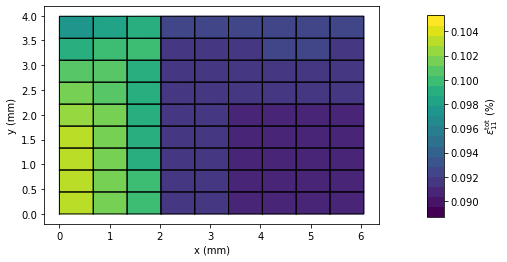

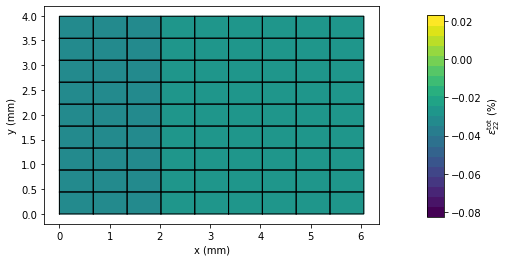

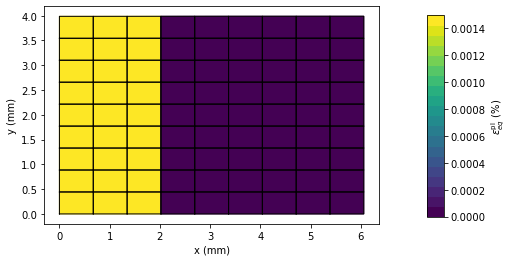

In [19]:
'laminate model is generated and elastic-plastic properties are assigned to each section'
fem = FE.Model(dim=2, planestress=True) # generate an object for a 2d finite element model with plane stress conditions
fem.geom([2, 2, 2], LY=4.)      # define 3 horizontal sections with 2 micron width per section, vertical dimension is 4 micron
fem.assign([mat1, mat2, mat3])  # assign the proper material to each section
fmat1 = 1./3.                   # identical volume fraction for each material
fmat2 = 1./3.
fmat3 = 1./3.
'boundary conditions: uniaxial stress in transversal direction'
fem.bcleft(0.)                     # fix left and bottom boundary in normal directions
fem.bcbot(0.)                      # nodes on lhs boundary can move up and down, bottom nodes can move left and right
fem.bctop(0., 'force')             # free boundary condition on top edge of plane stress model -> uniaxial stress condition
ubc = 1.05*fem.lenx*mat1.sy/mat1.E # displacement on rhs boundary corresponding to yield strength of mat1 (+5%)
fem.bcright(ubc, 'disp')           # displacement applied to rhs nodes
'generate mesh'
ny = 9
fem.mesh(NX=9, NY=ny)   # create structured mesh with higer number of elements in verical direction
'solution of equations for mechanical equilibrium'
fem.solve(verb=False)   # solve system of equations
'post-processing'
fem.calc_global()  # calculate global stress and strain
iel2 = 3*ny        # first element in section 2
iel3 = 6*ny        # first element in section 3

print('2-d Model: transversal uniaxial stress')
print('--------------------------------------')
print('Global total strain: (eps_11, eps_22) = (%9.6f, %9.6f)' 
      % (fem.glob['eps'][0].round(decimals=4), fem.glob['eps'][1].round(decimals=4)))
print('Local total strain (element solution in different sections, Voigt tensor)')
print(fem.element[0].eps.round(decimals=4),'in Section 1, Material: ', fem.element[0].Mat.name)
print(fem.element[iel2].eps.round(decimals=5),'in Section 2, Material: ', fem.element[iel2].Mat.name)
print(fem.element[iel3].eps.round(decimals=5),'in Section 3, Material: ', fem.element[iel3].Mat.name)
print('\nGlobal plastic strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['epl'][0].round(decimals=3), fem.glob['epl'][1].round(decimals=3)))
print('Local plastic strain (element solution in different sections, Voigt tensor):')
print(fem.element[0].epl.round(decimals=6),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[iel2].epl.round(decimals=6),' in Section 2, Material:',fem.element[iel2].Mat.name)
print(fem.element[iel3].epl.round(decimals=6),' in Section 3, Material:',fem.element[iel3].Mat.name)
'create graphical output of model'
fem.plot('strain1', shownodes=False)                   # plot eps_11
fem.plot('strain2', shownodes=False)                   # plot eps_22
fem.plot('peeq', shownodes=False,vmin=0.,vmax=0.0015)  # plot eqiv. plastic strain

Plastic yielding starts again in section 1, in which also the total strain localises. This causes also a slight difference in the cross contraction of section 1 compared to the other sections.


Global stress (MPa): (sig_11, sig_22) = (182.54,  0.00)
Local stress (element solution in different sections, Voigt tensor) (MPa):
[1.8362e+02 3.3600e+00 0.0000e+00 0.0000e+00 0.0000e+00 7.0000e-02]  in Section 1, Material: Soft
[ 1.8207e+02 -4.4300e+00  0.0000e+00  0.0000e+00  0.0000e+00  1.8000e-01]  in Section 2, Material: Intermediate
[ 1.8121e+02 -5.2000e-01  0.0000e+00  0.0000e+00  0.0000e+00  3.0000e-02]  in Section 3, Material: Strong


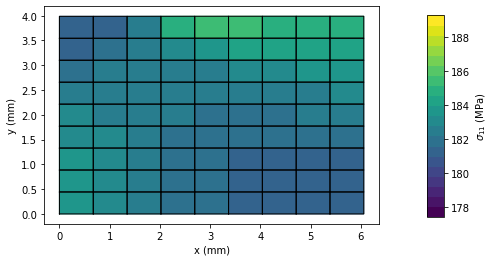

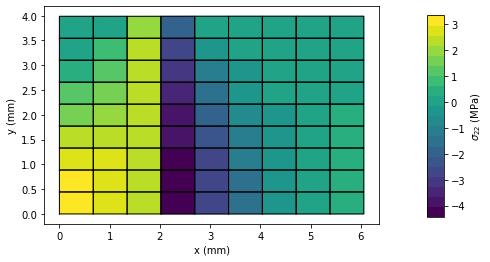

In [20]:
print('\nGlobal stress (MPa): (sig_11, sig_22) = (%5.2f, %5.2f)' 
      % (fem.glob['sig'][0].round(decimals=3), fem.glob['sig'][1].round(decimals=3)))
print('Local stress (element solution in different sections, Voigt tensor) (MPa):')
print(fem.element[0].sig.round(decimals=2),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[iel2].sig.round(decimals=2),' in Section 2, Material:',fem.element[iel2].Mat.name)
print(fem.element[iel3].sig.round(decimals=2),' in Section 3, Material:',fem.element[iel3].Mat.name)
fem.plot('stress1', shownodes=False)
fem.plot('stress2', shownodes=False)

The different cross-contractions of the sections cause significant stress components transversal to the loading direction. hence, altough the applied boundary condition correspond to a uniaxial stress, within the structure, the stress state deviates from the applied one. Note that the stresses are highest at the x-axis, because there the the displacements in y-direction are constrained to zero.

2-d Model: iso-stress, uniaxial strain
--------------------------------------
Global total strain: (epl_11, epl_22) = ( 0.001200, -0.000400)
Local total strain (element solution in different sections, Voigt tensor)
[ 0.0018 -0.0006 -0.0005  0.      0.      0.    ] in Section 1, Material:  Soft
[ 1.22e-03 -4.50e-04 -3.30e-04  0.00e+00  0.00e+00  1.00e-05] in Section 2, Material:  Intermediate
[ 0.00094 -0.00031 -0.00027  0.       0.       0.     ] in Section 3, Material:  Strong

Global plastic strain: (epl_11, epl_22) = ( 0.000000, -0.000000)
Local plastic strain (element solution in different sections, Voigt tensor):
[ 0.000793 -0.000377 -0.000416  0.        0.        0.      ]  in Section 1, Material: Soft
[ 0.000258 -0.000137 -0.000122  0.        0.        0.      ]  in Section 2, Material: Intermediate
[0. 0. 0. 0. 0. 0.]  in Section 3, Material: Strong


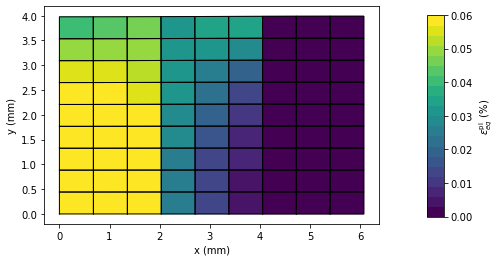


Global stress (MPa): (sig_11, sig_22) = (192.37, -0.00)
Local stress (element solution in different sections, Voigt tensor) (MPa):
[1.9684e+02 8.1400e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.7000e-01]  in Section 1, Material: Soft
[191.77  -4.42   0.     0.     0.     0.87]  in Section 2, Material: Intermediate
[ 1.8711e+02 -5.8600e+00  0.0000e+00  0.0000e+00  0.0000e+00  1.5000e-01]  in Section 3, Material: Strong


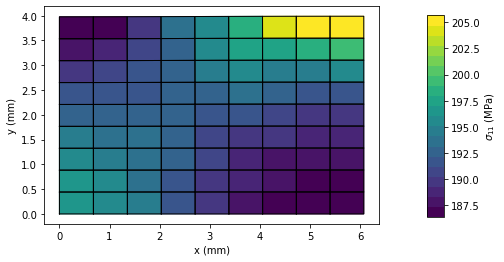

In [21]:
'increase load above the yield strength of mat2'
ubc = 1.3*fem.lenx*mat2.sy/mat2.E
fem.bcright(ubc, 'disp') # displacement on rhs nodes
fem.solve()              # solve equations for mechanical equilibrium

print('2-d Model: iso-stress, uniaxial strain')
print('--------------------------------------')
print('Global total strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['eps'][0].round(decimals=4), fem.glob['eps'][1].round(decimals=4)))
print('Local total strain (element solution in different sections, Voigt tensor)')
print(fem.element[0].eps.round(decimals=4),'in Section 1, Material: ', fem.element[0].Mat.name)
print(fem.element[iel2].eps.round(decimals=5),'in Section 2, Material: ', fem.element[iel2].Mat.name)
print(fem.element[iel3].eps.round(decimals=5),'in Section 3, Material: ', fem.element[iel3].Mat.name)
print('\nGlobal plastic strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['epl'][0].round(decimals=3), fem.glob['epl'][1].round(decimals=3)))
print('Local plastic strain (element solution in different sections, Voigt tensor):')
print(fem.element[0].epl.round(decimals=6),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[iel2].epl.round(decimals=6),' in Section 2, Material:',fem.element[iel2].Mat.name)
print(fem.element[iel3].epl.round(decimals=6),' in Section 3, Material:',fem.element[iel3].Mat.name)
fem.plot('peeq', shownodes=False, vmin=0., vmax=0.06)
print('\nGlobal stress (MPa): (sig_11, sig_22) = (%5.2f, %5.2f)' 
      % (fem.glob['sig'][0].round(decimals=3), fem.glob['sig'][1].round(decimals=3)))
print('Local stress (element solution in different sections, Voigt tensor) (MPa):')
print(fem.element[0].sig.round(decimals=2),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[iel2].sig.round(decimals=2),' in Section 2, Material:',fem.element[iel2].Mat.name)
print(fem.element[iel3].sig.round(decimals=2),' in Section 3, Material:',fem.element[iel3].Mat.name)
fem.plot('stress1', shownodes=False)

Upon further loading, the work hardening in section 1 causes the flow stress in this region to increase. Finally, the stress in the laminate structure exceeds the yield strength of the material in section 2. The iso-stress condition is fulfilled to some approximation in the structure, although the different sections reveal pronounced differences in the cross-contraction.

2-d Model: iso-stress, uniaxial strain
--------------------------------------
Global total strain: (epl_11, epl_22) = ( 0.010000, -0.004600)
Local total strain (element solution in different sections, Voigt tensor)
[ 0.0115 -0.0052 -0.0027  0.      0.      0.    ] in Section 1, Material:  Soft
[ 1.064e-02 -4.790e-03 -2.510e-03  0.000e+00  0.000e+00  1.000e-05] in Section 2, Material:  Intermediate
[ 0.00804 -0.00407 -0.0017   0.       0.       0.     ] in Section 3, Material:  Strong

Global plastic strain: (epl_11, epl_22) = ( 0.008000, -0.004000)
Local plastic strain (element solution in different sections, Voigt tensor):
[ 0.009769 -0.004727 -0.005042  0.        0.        0.      ]  in Section 1, Material: Soft
[ 0.008955 -0.004304 -0.004652  0.        0.        0.      ]  in Section 2, Material: Intermediate
[ 0.0066   -0.003667 -0.002933  0.        0.        0.      ]  in Section 3, Material: Strong


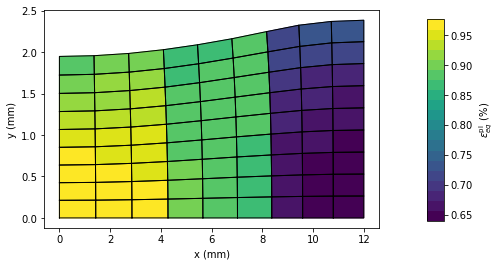

In [22]:
'increase load up to 1% strain'
ubc = 0.01*fem.lenx
fem.bcright(ubc, 'disp') # displacement on rhs nodes
fem.solve()              # solve equations for mechanical equilibrium
fem.calc_global()        # calculate global stress and strain

print('2-d Model: iso-stress, uniaxial strain')
print('--------------------------------------')
print('Global total strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['eps'][0].round(decimals=4), fem.glob['eps'][1].round(decimals=4)))
print('Local total strain (element solution in different sections, Voigt tensor)')
print(fem.element[0].eps.round(decimals=4),'in Section 1, Material: ', fem.element[0].Mat.name)
print(fem.element[iel2].eps.round(decimals=5),'in Section 2, Material: ', fem.element[iel2].Mat.name)
print(fem.element[fem.Nel-ny].eps.round(decimals=5),'in Section 3, Material: ', fem.element[fem.Nel-ny].Mat.name)
print('\nGlobal plastic strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['epl'][0].round(decimals=3), fem.glob['epl'][1].round(decimals=3)))
print('Local plastic strain (element solution in different sections, Voigt tensor):')
print(fem.element[0].epl.round(decimals=6),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[iel2].epl.round(decimals=6),' in Section 2, Material:',fem.element[iel2].Mat.name)
print(fem.element[iel3].epl.round(decimals=6),' in Section 3, Material:',fem.element[iel3].Mat.name)
fem.plot('peeq', mag=100, shownodes=False)

At the maximum strain, the laminate structure is again fully plastified. The plastic strains in the different sections reflects the different states of work hardening in the associated materials.


Global stress (MPa): (sig_11, sig_22) = (334.88, -0.00)
Local stress (element solution in different sections, Voigt tensor) (MPa):
[3.4228e+02 7.5800e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.6000e-01]  in Section 1, Material: Soft
[337.93   4.9    0.     0.     0.     0.85]  in Section 2, Material: Intermediate
[330.53 -13.26   0.     0.     0.     0.81]  in Section 3, Material: Strong


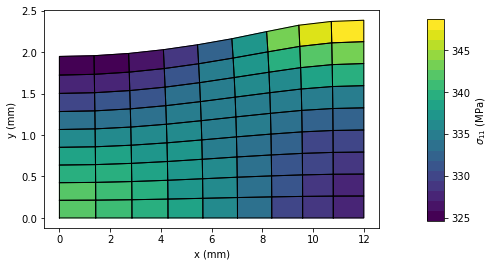

In [23]:
print('\nGlobal stress (MPa): (sig_11, sig_22) = (%5.2f, %5.2f)' 
      % (fem.glob['sig'][0].round(decimals=3), fem.glob['sig'][1].round(decimals=3)))
print('Local stress (element solution in different sections, Voigt tensor) (MPa):')
print(fem.element[0].sig.round(decimals=2),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[iel2].sig.round(decimals=2),' in Section 2, Material:',fem.element[iel2].Mat.name)
print(fem.element[iel3].sig.round(decimals=2),' in Section 3, Material:',fem.element[iel3].Mat.name)
fem.plot('stress1', mag=100, shownodes=False)

The iso-stress assumption is still fulfilled within an error margin of 10%, despite the different cross contractions that are magnified here with a factor of 100 to illustrate the shape under deformation fulfilling uniaxial stress conditions, i.e. with free relaxation of the cross-contractions.

In the final step, force boundary condition are applied to produce a global stress of 335MPa, corresponding approximately to the global stress at the strain of 1%, i.e., the value applied above. Force boundary conditions allow for more flexibility of the boundary nodes on the r.h.s. of the model.

2-d Model: transversal uniaxial stress - force BC
-------------------------------------------------
Global total strain: (eps_11, eps_22) = ( 0.010000, -0.004700)
Local total strain (element solution in different sections, Voigt tensor)
[ 0.0115 -0.0053 -0.0026  0.      0.      0.    ] in Section 1, Material:  Soft
[ 0.01079 -0.00501 -0.00248  0.       0.       0.     ] in Section 2, Material:  Intermediate
[ 0.00854 -0.00437 -0.00179  0.       0.       0.     ] in Section 3, Material:  Strong


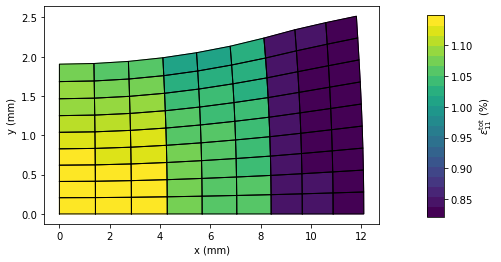

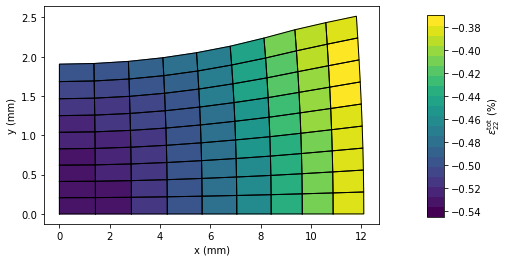


Global plastic strain: (epl_11, epl_22) = ( 0.008000, -0.004000)
Local plastic strain (element solution in different sections, Voigt tensor):
[ 0.009795 -0.004848 -0.004947  0.        0.        0.      ]  in Section 1, Material: Soft
[ 0.009104 -0.004514 -0.00459   0.        0.        0.      ]  in Section 2, Material: Intermediate
[ 0.006849 -0.00381  -0.003039  0.        0.        0.      ]  in Section 3, Material: Strong


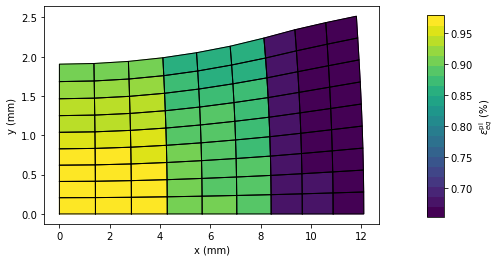


Global stress (MPa): (sig_11, sig_22) = (335.00, -0.00)
Local stress (element solution in different sections, Voigt tensor) (MPa):
[3.4062e+02 3.3000e+00 0.0000e+00 0.0000e+00 0.0000e+00 9.0000e-02]  in Section 1, Material: Soft
[3.3861e+02 2.1400e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.3000e-01]  in Section 2, Material: Intermediate
[ 3.3568e+02 -1.1430e+01  0.0000e+00  0.0000e+00  0.0000e+00  2.8000e-01]  in Section 3, Material: Strong


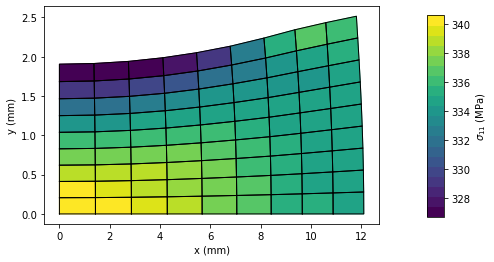

In [24]:
'laminate model is generated and elastic-plastic properties are assigned to each section'
fem = FE.Model(dim=2, planestress=True) # generate an object for a 2d finite element model with plane stress conditions
fem.geom([2, 2, 2], LY=4.)      # define 3 horizontal sections with 2 micron width per section, vertical dimension is 4 micron
fem.assign([mat1, mat2, mat3])  # assign the proper material to each section
fmat1 = 1./3.                   # identical volume fraction for each material
fmat2 = 1./3.
fmat3 = 1./3.
'boundary conditions: uniaxial stress in transversal direction'
fem.bcleft(0.)                     # fix left and bottom boundary in normal directions
fem.bcbot(0.)                      # nodes on lhs boundary can move up and down, bottom nodes can move left and right
fem.bctop(0., 'force')             # free boundary condition on top edge of plane stress model -> uniaxial stress condition
fem.bcright(335.*fem.leny, 'force')    # force applied to rhs nodes
'generate mesh'
ny = 9
fem.mesh(NX=9, NY=ny)   # create structured mesh with higer number of elements in verical direction
'solution of equations for mechanical equilibrium'
fem.solve(verb=False)   # solve system of equations
'post-processing'
iel2 = 3*ny        # first element in section 2
iel3 = 6*ny        # first element in section 3

print('2-d Model: transversal uniaxial stress - force BC')
print('-------------------------------------------------')
print('Global total strain: (eps_11, eps_22) = (%9.6f, %9.6f)' 
      % (fem.glob['eps'][0].round(decimals=4), fem.glob['eps'][1].round(decimals=4)))
print('Local total strain (element solution in different sections, Voigt tensor)')
print(fem.element[0].eps.round(decimals=4),'in Section 1, Material: ', fem.element[0].Mat.name)
print(fem.element[iel2].eps.round(decimals=5),'in Section 2, Material: ', fem.element[iel2].Mat.name)
print(fem.element[iel3].eps.round(decimals=5),'in Section 3, Material: ', fem.element[iel3].Mat.name)
fem.plot('strain1', mag=100, shownodes=False)  # plot eps_11
fem.plot('strain2', mag=100, shownodes=False)  # plot eps_22

print('\nGlobal plastic strain: (epl_11, epl_22) = (%9.6f, %9.6f)' 
      % (fem.glob['epl'][0].round(decimals=3), fem.glob['epl'][1].round(decimals=3)))
print('Local plastic strain (element solution in different sections, Voigt tensor):')
print(fem.element[0].epl.round(decimals=6),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[iel2].epl.round(decimals=6),' in Section 2, Material:',fem.element[iel2].Mat.name)
print(fem.element[iel3].epl.round(decimals=6),' in Section 3, Material:',fem.element[iel3].Mat.name)
fem.plot('peeq', mag=100, shownodes=False)     # plot eqiv. plastic strain

print('\nGlobal stress (MPa): (sig_11, sig_22) = (%5.2f, %5.2f)' 
      % (fem.glob['sig'][0].round(decimals=3), fem.glob['sig'][1].round(decimals=3)))
print('Local stress (element solution in different sections, Voigt tensor) (MPa):')
print(fem.element[0].sig.round(decimals=2),' in Section 1, Material:',fem.element[0].Mat.name)
print(fem.element[iel2].sig.round(decimals=2),' in Section 2, Material:',fem.element[iel2].Mat.name)
print(fem.element[iel3].sig.round(decimals=2),' in Section 3, Material:',fem.element[iel3].Mat.name)
fem.plot('stress1', mag=100, shownodes=False)  # plot eqiv. stress

It is seen that the iso-stress condition is fulfilled to a better degree with force boundary conditions, for which the r.h.s edge of the model takes a rounded shape.

## 4. Summary
This tutorial demonstrates the homogenization of structures composed of materials with different elastic-plastic properties by non-linear FEA. Models fhe different load cases leading to iso-strain and iso-stress conditions in the structures are set up and the results are analyzed. It is seen that the numerical solution agrees very well with the analyitcal homogenization rules according to the Taylor and Sachs models.

## 5. Exercises
- Create materials with different hardening rates, e.g. 100 GPa for ``mat1``, 50 GPa for ``mat2`` and 10 GPa for ``mat3`` and observe how the homogenized stress behaves in that case. 
- Create a model in which the sections are not equally distributed and verify the correctness of the Taylor and Sachs models in this case.
- Assign a purely elastic material to one of the sections and study the behavior of the structure.